In [1]:
import pandas as pd
import numpy as np
import os
import math

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
root_dir = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/WH04/4A_outputs/"

experiments = {
    "B3" : "PRRX1",
}

df_list = []

for _dir, condition in experiments.items():
    tracks_path = f"{root_dir}{_dir}/Track statistics_ellipse.csv"
    tracks = pd.read_csv(tracks_path)
    
    spots_path = f"{root_dir}{_dir}/All Spots statistics_ellipse.csv"
    spots = pd.read_csv(spots_path)
    
    # convert types
    spots = spots[spots['TRACK_ID'] != "None"]
    spots = spots.astype({"TRACK_ID": int})
    
    tracks = tracks.astype({"TRACK_ID": int})
    
    # merge 
    tmp = pd.merge(spots, tracks, how='left', on=['TRACK_ID'])
    
    # sort by ID then FRAME
    tmp = tmp.sort_values(by=['TRACK_ID', 'FRAME'])

    # add a grouped step 
    tmp.loc[:, 'STEP'] =  tmp.groupby(['TRACK_ID']).cumcount()
    tmp.loc[:, 'NORMED_STEP'] = tmp['STEP'] / tmp['TRACK_DURATION']
    
    tmp['Scene'] = _dir
    tmp['Condition'] = condition
    tmp['Time'] = (tmp['FRAME'] * 25) / 60
    
    tmp['TRACK_ID'] = tmp['TRACK_ID'].astype(str) + "_" + str(_dir)
    df_list.append(tmp)
    
# build master data structure 
df = pd.concat(df_list, ignore_index=True)

# subset the columns to make processing easier
cols = [
    'TRACK_ID', 
    'QUALITY', 
    'SNR',
    'POSITION_X',
    'POSITION_Y',
    'FRAME', 
    'Time',
    'STEP',
    'NORMED_STEP',
    'RADIUS',
    'MEAN_INTENSITY01', 
    'MEAN_INTENSITY02',
    'MEAN_INTENSITY03',
    'MEAN_TRACK_INTENSITY01',
    'MEAN_TRACK_INTENSITY02',
    'MEAN_TRACK_INTENSITY03',
    'TOTAL_DISTANCE_TRAVELED',
    'TRACK_DURATION',
    'Scene',
    'Condition'
]

df = df[cols]


df.head()

,TRACK_ID,QUALITY,SNR,POSITION_X,POSITION_Y,FRAME,Time,STEP,NORMED_STEP,RADIUS,MEAN_INTENSITY01,MEAN_INTENSITY02,MEAN_INTENSITY03,MEAN_TRACK_INTENSITY01,MEAN_TRACK_INTENSITY02,MEAN_TRACK_INTENSITY03,TOTAL_DISTANCE_TRAVELED,TRACK_DURATION,Scene,Condition
0,0_B3,1827,NaN,1794.245,1815.317,0,0.000000,0,0.000000,10.054,0.0,0.0,224.019,0.0,46.493,219.604,263.542,111117.023,B3,PRRX1
1,0_B3,4492,NaN,1791.117,1818.029,1,0.416667,1,0.000009,8.088,0.0,0.0,231.534,0.0,46.493,219.604,263.542,111117.023,B3,PRRX1
2,0_B3,7138,NaN,1787.716,1817.260,2,0.833333,2,0.000018,7.004,0.0,0.0,235.272,0.0,46.493,219.604,263.542,111117.023,B3,PRRX1
3,0_B3,9767,NaN,1776.835,1807.158,3,1.250000,3,0.000027,5.601,0.0,0.0,242.308,0.0,46.493,219.604,263.542,111117.023,B3,PRRX1
4,0_B3,12397,NaN,1762.083,1797.340,4,1.666667,4,0.000036,7.506,0.0,0.0,221.041,0.0,46.493,219.604,263.542,111117.023,B3,PRRX1


In [3]:
# normalize the intensities and create binary flags
df['mCherry'] = df['MEAN_INTENSITY01'] / 255
df['mVenus'] = df['MEAN_INTENSITY02']  / 255
df['H2B'] = df['MEAN_INTENSITY03']  / 255

# normalize to the highest intensity in the track
df['track_mCherry_max'] = df.groupby('TRACK_ID')['mCherry'].transform(np.max)
df['track_mVenus_max'] = df.groupby('TRACK_ID')['mVenus'].transform(np.max)

df['normed_mCherry'] = df['mCherry'] / df['track_mCherry_max']
df['normed_mVenus'] =df['mVenus'] / df['track_mVenus_max']

# binary flags for track that have any detetable PF signal
df['ANY_mCherry'] = np.where(df['mCherry'] > 0, 1, 0)
df['ANY_mVenus'] = np.where(df['mVenus'] > 0, 1, 0)
df['ANY_H2B'] = np.where(df['H2B'] > 0, 1, 0)

df['has_mCherry'] = df.groupby(['TRACK_ID', 'Condition'])['ANY_mCherry'].transform(np.max)
df['has_mVenus'] = df.groupby(['TRACK_ID', 'Condition'])['ANY_mVenus'].transform(np.max)
df['has_H2B'] = df.groupby(['TRACK_ID', 'Condition'])['ANY_H2B'].transform(np.max)

In [4]:
QUALITY_THRESHOLD = 1.8
MIN_MAX_STEP = 10

# exclude tracks with no positive PF signal
print(df.shape)
print(df['TRACK_ID'].nunique())

# filter for positive PF signal
df = df[df['has_mVenus'] == 1]
df = df[df['has_mCherry'] == 1]

# create mean track quality and SNR measures
df['mean_quality'] = df.groupby(['TRACK_ID'])['QUALITY'].transform(np.mean)
df['max_step'] = df.groupby(['TRACK_ID'])['STEP'].transform(np.max)

df = df[df['mean_quality'] > QUALITY_THRESHOLD]
df = df[df['max_step'] > MIN_MAX_STEP]

print(df.shape)
print(df['TRACK_ID'].nunique())

(51879, 33)
4229
(16849, 35)
948


In [5]:
# frame-based normalization factors
grped = df.groupby(['Time', 'Condition'], as_index=False).agg(
    mCherry_mean = ('normed_mCherry', np.mean),
    mCherry_std = ('normed_mCherry', np.std),
    mCherry_median = ('normed_mCherry', np.median),
    
    mVenus_mean = ('normed_mVenus', np.mean),
    mVenus_std = ('normed_mVenus', np.std),
    mVenus_median = ('normed_mVenus', np.median),
)

df = pd.merge(df, grped, on=['Time', 'Condition'], how='left')

#state decision rules
df['mVenus_BINARY'] = np.where(df['mVenus'] > df['mVenus_median'], 1, 0)
df['mCherry_BINARY'] = np.where(df['mCherry'] > df['mCherry_median'], 1, 0)

df['state_guess'] = np.where((df['mVenus_BINARY'] == 1) & (df['mCherry_BINARY'] == 1 ), 'G2/M', 'G1')
df['state_guess'] = np.where((df['mVenus_BINARY'] == 0) & (df['mCherry_BINARY'] == 1 ), 'S', df['state_guess'])

print(df['state_guess'].value_counts(dropna=False))

G1      10635
S        3716
G2/M     2498
Name: state_guess, dtype: int64


Text(0.5, 1.0, '1177_B3')

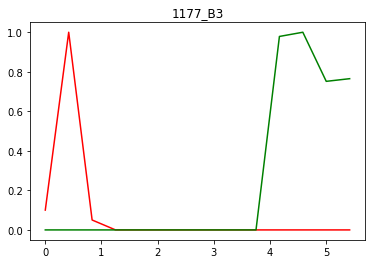

In [6]:
rid = np.random.choice(df['TRACK_ID'], 1)[0]
# rid = "33_B5"

tmp = df[df['TRACK_ID'] == rid]

plt.plot(tmp['Time'], tmp['normed_mCherry'], c='r')
plt.plot(tmp['Time'], tmp['normed_mVenus'], c='g')
plt.title(rid)

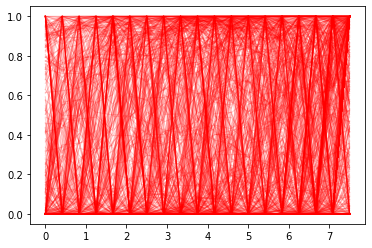

In [9]:
df['FRAME'].min()

for tid in df['TRACK_ID'].unique():
    tmp = df[df['TRACK_ID'] == tid]
    
    tmp = tmp.sort_values(by='FRAME')
    
    plt.plot(tmp['Time'], tmp['normed_mCherry'], c='r', lw=1, alpha=0.2)